In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook
# import load_raw as Raw
import seaborn as sns
from scipy.special import expit as logit
from sklearn.model_selection import train_test_split
from scipy.special import expit as sigmoid # is more stable in case of overflows
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, \
recall_score, precision_score, accuracy_score, confusion_matrix
import math, random

from sklearn.neural_network import MLPClassifier

# Prepare data

In [2]:
# df_cleaned = pd.read_csv('/data/ortho/AllPatients.csv',  sep= ';')
# df_cleaned = pd.read_csv('../2. miscellaneous/AllPatients_SuperCleaned.csv',  sep= ';')
df_cleaned = pd.read_csv('../2. miscellaneous/Supercleaned_alpha.csv',  sep= ';')
# df_cleaned = pd.read_csv('../2. miscellaneous/Supercleaned_bravo.csv',  sep= ';')
# df_cleaned = pd.read_csv('../2. miscellaneous/Supercleaned_charlie.csv',  sep= ';')
# df_cleaned = pd.read_csv('../2. miscellaneous/Supercleaned_delta.csv',  sep= ';')
# df_cleaned = pd.read_csv('../2. miscellaneous/Supercleaned_echo.csv',  sep= ';')

# x is naar rechts
# y is omhoog
# z is rotatie????

In [3]:
# bereken symmetrie
df_cleaned['clavicula_x_dif'] = np.absolute(df_cleaned['clavicula_l_x'] - df_cleaned['clavicula_r_x'])
df_cleaned['clavicula_y_dif'] = np.absolute(df_cleaned['clavicula_l_y'] - df_cleaned['clavicula_r_y'])
df_cleaned['clavicula_z_dif'] = np.absolute(df_cleaned['clavicula_l_z'] - df_cleaned['clavicula_r_z'])

df_cleaned['scapula_x_dif'] = np.absolute(df_cleaned['scapula_l_x'] - df_cleaned['scapula_r_x'])
df_cleaned['scapula_y_dif'] = np.absolute(df_cleaned['scapula_l_y'] - df_cleaned['scapula_r_y'])
df_cleaned['scapula_z_dif'] = np.absolute(df_cleaned['scapula_l_z'] - df_cleaned['scapula_r_z'])

df_cleaned['humerus_x_dif'] = np.absolute(df_cleaned['humerus_l_x'] - df_cleaned['humerus_r_x'])
df_cleaned['humerus_y_dif'] = np.absolute(df_cleaned['humerus_l_y'] - df_cleaned['humerus_r_y'])
df_cleaned['humerus_z_dif'] = np.absolute(df_cleaned['humerus_l_z'] - df_cleaned['humerus_r_z'])

# hulp array, met alle parameters die voor de classifier gebruikt worden, je kan hier alles in doen wat je wilt
param = [ \
          'humerus_l_x', 'humerus_l_y', 'humerus_l_z', 'humerus_r_x', 'humerus_r_y', 'humerus_r_z', \
          'clavicula_l_x', 'clavicula_l_y', 'clavicula_l_z', 'clavicula_r_x', 'clavicula_r_y', 'clavicula_r_z', \
          'scapula_l_x', 'scapula_l_y', 'scapula_l_z', 'scapula_r_x', 'scapula_r_y', 'scapula_r_z', \
          'clavicula_x_dif','clavicula_y_dif','clavicula_z_dif', \
          'scapula_x_dif','scapula_y_dif','scapula_z_dif', \
          'humerus_x_dif', 'humerus_y_dif', 'humerus_z_dif'
         ]

df_cleaned['bias'] = 1

# split oorsprong kolom in onderdelen
x,y = df_cleaned['Oorsprong'].str.split(".").str #Oordprong word vertaald naar een string en wordt gesplits op de punt 
df_cleaned['cat'],df_cleaned['pat'],df_cleaned['meting'],df_cleaned['oef'],df_cleaned['split'] = x.str.split("_").str #4 categorieen gemaakt obv file name
df_cleaned['cat'] = [ int(x[3:]) for x in df_cleaned['cat']] #voor elk 3+ element in de kolom wordt vertaald naar een int
df_cleaned['meting'] = [ int(x[6:]) for x in df_cleaned['meting']] 
df_cleaned['oef'] = [ int(x[3:]) for x in df_cleaned['oef']] 
df_cleaned['pat'] = [ int(x[3:]) for x in df_cleaned['pat']] 
#na deze regels te hebben uitgevoerd zijn er nieuwe categorieen met ints.

df_cleaned['pat'] = df_cleaned['cat']*1000+df_cleaned['pat'] #geef elke patient een uniek nummer

#maak boolean kolom per categorie
df_cleaned['c4'] = ['Cat4' in vincent for vincent in df_cleaned['Oorsprong']]
df_cleaned['c3'] = ['Cat3' in vincent for vincent in df_cleaned['Oorsprong']]
df_cleaned['c2'] = ['Cat2' in vincent for vincent in df_cleaned['Oorsprong']]
df_cleaned['c1'] = ['Cat1' in vincent for vincent in df_cleaned['Oorsprong']]


# Define functions

In [4]:
# functie om plot van 2 van de variabelen uit de tabel df_cleaned te maken
def scatter(param1, param2):
    cat4 = df_cleaned.where(df_cleaned['c4'])
    cat3 = df_cleaned.where(df_cleaned['c3'])
    cat2 = df_cleaned.where(df_cleaned['c2'])
    cat1 = df_cleaned.where(df_cleaned['c1'])

    plt.plot(cat3[param1], cat3[param2], '.', color='red', markersize=2)
    plt.plot(cat1[param1], cat1[param2], '.', color='cyan', markersize=2)
    plt.plot(cat2[param1], cat2[param2], '.', color='green', markersize=2)
    plt.plot(cat4[param1], cat4[param2], '.', color='blue', markersize=2)
    plt.title(param1+'/'+param2)
    plt.ylabel(param1)
    plt.xlabel(param2);

def plot_decision_boundary(theta):
    ax = plt.gca()
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                         np.arange(y_min, y_max, 1))

    X = np.matrix(np.vstack([np.ones(xx.shape[0] * xx.shape[1]), xx.ravel(), yy.ravel()])).T
    boundary = logit(X * theta)
    boundary = boundary.reshape(xx.shape)

    ax.contour(xx, yy,
           boundary,
           levels=[0.5])

def logit(z):
    return 1.0 / (1.0 + np.exp(-z))

def predict(X, theta):
    return h(X, theta) >= 0.5

def PlotData(Paramater1, Paramater2):
    # maak plotje van 2 variabelen
    # Scatter all data in different colors
    scatter(param[Paramater1-1],param[Paramater2-1])
    
    #Draw four decision boundaries
    for i in classes:
        theta =  Data[class_2b_found]['Model'].coef_.flatten()
        selectedtheta = np.array([theta[0], theta[Paramater1], theta[Paramater2]])
        selectedtheta = np.reshape(selectedtheta,(3,1))
        plot_decision_boundary(selectedtheta)
    plt.show()
    return

def CalculatePerc(cat, CountF1, CountF2, CountF3, CountF4):
    Count = [CountF1, CountF2, CountF3, CountF4]
    cat = int(cat)
    perc = 100*Count[cat-1]/np.nansum(Count)
    if(math.isnan(perc)):
        perc = 0
    return perc

def CategorieStringToNum(index):
    string = str(index)
    cat = string[0]
    return cat

def SplitData(df, xcol, ycol, percentage):
    allIndex = np.unique(df['pat'].tolist()) # Get all unique patients id's
    random.seed(2) # Set random seeed so the answer is the same
    
    PercentageIndex = []
    for i in np.unique(np.floor(allIndex / 1000)): # Cycle through each categorie (only cycles through the ones that are present)
        CatPatients = allIndex[allIndex<((i+1)*1000)] # Filters out patients who are bigger then our max
        CatPatients = CatPatients[CatPatients>=((i)*1000)] # Filters out patients that are smaller
        
        AmountItems = len(CatPatients)
        AmountRandom = math.floor(AmountItems*percentage)
        PercentageIndex.extend(random.sample(list(CatPatients), AmountRandom))        
        
    AmountItems = len(allIndex)
    AmountRandom = math.floor(AmountItems*percentage)
    
    PercentageIndex = random.sample(list(allIndex), AmountRandom)
#     print(PercentageIndex)
    Percentagedf = df[xcol][df['pat'].isin(PercentageIndex)]
    Percentagey = df[ycol][df['pat'].isin(PercentageIndex)]
    
    Testdf = df[xcol][~df['pat'].isin(PercentageIndex)]
    Testy = df[ycol][~df['pat'].isin(PercentageIndex)]
    
    return (Percentagedf, Testdf, Percentagey, Testy)



# Learn models (x4)

In [5]:
# Doe hier alles wat niet in de loop gedaan hoeft te worden
    # Bereid de data opslag voor van de loop
classes = ['c1','c2','c3','c4']

Data = {}
for i in classes:
    Data[i] = {'result': None, 
               'X_train': None,
               'X_test': None, 
               'y_train': None, 
               'y_test': None, 
               'Model': None}
    # Einde data opslag voorbereiden



#hulpvariabele geeft aan welke categorie we willen onderscheiden
Xcolumns = ['bias']
Xcolumns.extend(param)

for class_2b_found in classes:
    classnum = int(class_2b_found[1])
    # <-- Begin model moken -->
#     X = df_cleaned[Xcolumns]
#     y = df_cleaned[class_2b_found]

    # Split Data into a test and train set
    Data[class_2b_found]['X_train'], \
    Data[class_2b_found]['X_test'], \
    Data[class_2b_found]['y_train'], \
    Data[class_2b_found]['y_test'] = SplitData(df_cleaned, Xcolumns, class_2b_found, 0.8)

    
    # De keuze voor een classifier is "LogisticRegression", vandaar dat lr= LogisticRegression
#     Data[class_2b_found]['Model'] = LogisticRegression()
    Data[class_2b_found]['Model'] = MLPClassifier(hidden_layer_sizes=(2),solver='adam', random_state=21,tol=0.00001,learning_rate='adaptive',verbose=10)
    
    

    # Fit het model, met de train data (80 % )
    Data[class_2b_found]['Model'].fit(\
        Data[class_2b_found]['X_train'], Data[class_2b_found]['y_train'])
    # <-- Einde model maken -->
    
    
    # <-- Start percentage check -->
    # kolom met voorspelling toevoegen aan data
    # predict of de test data goed past bij deze LogisticRegression
    y_pred = Data[class_2b_found]['Model'].predict(Data[class_2b_found]['X_test'])
    
    PercentageDf = pd.DataFrame() # Create new dataframe
    PercentageDf['index'] = Data[class_2b_found]['X_test'].index # Get the index of the test data
    PercentageDf['predict'] = y_pred # Paste the True/False value in the predict column
    PercentageDf = PercentageDf.set_index('index') # zet de colom index als de index voor de join hierna
    PercentageDf = PercentageDf.join(df_cleaned[['pat', 'cat']]) # Join de pat en cat colom op de index
#     PercentageDf['ShouldBe'] = np.where(PercentageDf['cat'] == classnum, True, False)
#     PercentageDf['Correct2'] = np.where(PercentageDf['ShouldBe'] == PercentageDf['predict'], True, False)
    PercentageDf = PercentageDf.groupby(['pat','predict']).size().to_frame('count').reset_index() # Count the True and False grouped by patients
    
    
    PercentageDf = PercentageDf.pivot(index='pat', columns='predict', values='count') # Creeer een pivot tabel waar de true and false naar colommen gezet worden ipv twee rijen per patient
    PercentageDf.columns = ['countF', 'countT'] # Hernoem de colommen naar CountF en CountT
    PercentageDf['percentage'] = np.nan_to_num(100 * PercentageDf['countT'] / (PercentageDf['countT'] + PercentageDf['countF'])) # Bereken het percentage dat goed geraden is


    Data[class_2b_found]['result'] = PercentageDf
    # <-- End Percentage check -->

Iteration 1, loss = 1.27130328
Iteration 2, loss = 0.84056584
Iteration 3, loss = 0.73519256
Iteration 4, loss = 0.64906520
Iteration 5, loss = 0.56359898
Iteration 6, loss = 0.51234928
Iteration 7, loss = 0.47489047
Iteration 8, loss = 0.43829329
Iteration 9, loss = 0.40446716
Iteration 10, loss = 0.37952374
Iteration 11, loss = 0.36091809
Iteration 12, loss = 0.34557040
Iteration 13, loss = 0.33289526
Iteration 14, loss = 0.32317434
Iteration 15, loss = 0.31479419
Iteration 16, loss = 0.30681371
Iteration 17, loss = 0.29718628
Iteration 18, loss = 0.29034318
Iteration 19, loss = 0.28448156
Iteration 20, loss = 0.27948077
Iteration 21, loss = 0.27742981
Iteration 22, loss = 0.27248830
Iteration 23, loss = 0.26980031
Iteration 24, loss = 0.26676411
Iteration 25, loss = 0.26380781
Iteration 26, loss = 0.26175345
Iteration 27, loss = 0.25985684
Iteration 28, loss = 0.25777420
Iteration 29, loss = 0.25833524
Iteration 30, loss = 0.25483312
Iteration 31, loss = 0.25380065
Iteration 32, los

Iteration 71, loss = 0.60303055
Iteration 72, loss = 0.60297167
Iteration 73, loss = 0.60330466
Iteration 74, loss = 0.60310457
Iteration 75, loss = 0.60327517
Iteration 76, loss = 0.60285624
Iteration 77, loss = 0.60283744
Iteration 78, loss = 0.60320410
Iteration 79, loss = 0.60294866
Iteration 80, loss = 0.60333585
Iteration 81, loss = 0.60273894
Iteration 82, loss = 0.60274837
Iteration 83, loss = 0.60285581
Iteration 84, loss = 0.60273377
Iteration 85, loss = 0.60259639
Iteration 86, loss = 0.60258617
Iteration 87, loss = 0.60302591
Iteration 88, loss = 0.60274007
Iteration 89, loss = 0.60259009
Iteration 90, loss = 0.60259139
Iteration 91, loss = 0.60271620
Iteration 92, loss = 0.60276403
Iteration 93, loss = 0.60243501
Iteration 94, loss = 0.60262268
Iteration 95, loss = 0.60273814
Iteration 96, loss = 0.60245582
Iteration 97, loss = 0.60242789
Iteration 98, loss = 0.60274080
Iteration 99, loss = 0.60253709
Iteration 100, loss = 0.60249613
Iteration 101, loss = 0.60242387
Iterat

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.94040180
Iteration 3, loss = 0.83474061
Iteration 4, loss = 0.78785040
Iteration 5, loss = 0.75606678
Iteration 6, loss = 0.72808392
Iteration 7, loss = 0.69755796
Iteration 8, loss = 0.65360866
Iteration 9, loss = 0.61377591
Iteration 10, loss = 0.58756378
Iteration 11, loss = 0.56606189
Iteration 12, loss = 0.54489552
Iteration 13, loss = 0.52964263
Iteration 14, loss = 0.51774244
Iteration 15, loss = 0.50620043
Iteration 16, loss = 0.49495417
Iteration 17, loss = 0.48778011
Iteration 18, loss = 0.48362329
Iteration 19, loss = 0.48066166
Iteration 20, loss = 0.47835899
Iteration 21, loss = 0.47607375
Iteration 22, loss = 0.47430960
Iteration 23, loss = 0.47239049
Iteration 24, loss = 0.47092154
Iteration 25, loss = 0.46947758
Iteration 26, loss = 0.46850548
Iteration 27, loss = 0.46748544
Iteration 28, loss = 0.46638282
Iteration 29, loss = 0.46522183
Iteration 30, loss = 0.46433913
Iteration 31, loss = 0.46363220
Iteration 32, loss = 0.46286661
Iteration 33, lo

Iteration 72, loss = 0.03323588
Iteration 73, loss = 0.03354282
Iteration 74, loss = 0.03298651
Iteration 75, loss = 0.03330670
Iteration 76, loss = 0.03285563
Iteration 77, loss = 0.03308864
Iteration 78, loss = 0.03294819
Iteration 79, loss = 0.03287578
Iteration 80, loss = 0.03337599
Iteration 81, loss = 0.03286431
Iteration 82, loss = 0.03278903
Iteration 83, loss = 0.03361141
Iteration 84, loss = 0.03254204
Iteration 85, loss = 0.03280668
Iteration 86, loss = 0.03254098
Iteration 87, loss = 0.03281948
Iteration 88, loss = 0.03237497
Iteration 89, loss = 0.03286450
Iteration 90, loss = 0.03267679
Iteration 91, loss = 0.03235238
Iteration 92, loss = 0.03258581
Iteration 93, loss = 0.03227729
Iteration 94, loss = 0.03240029
Iteration 95, loss = 0.03219215
Iteration 96, loss = 0.03220377
Iteration 97, loss = 0.03232979
Iteration 98, loss = 0.03218466
Iteration 99, loss = 0.03206547
Iteration 100, loss = 0.03264937
Iteration 101, loss = 0.03195603
Iteration 102, loss = 0.03229239
Itera

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Visualize it

AttributeError: 'MLPClassifier' object has no attribute 'coef_'

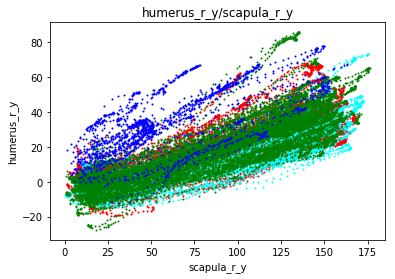

In [6]:
PlotData(5,17)

# Theta check

In [ ]:
newparam = ['bias']
newparam.extend(param)

for cat in classes:
    ParamCheck = pd.DataFrame()
    ParamCheck['Params'] = newparam
    ParamCheck['Theta'] = list(Data[cat]['Model'].coef_)[0]
    ParamCheck['Absolute'] = np.absolute(list(ParamCheck['Theta']))
    ParamCheck = ParamCheck.sort_values(by=['Absolute'] , ascending=False)
    print(ParamCheck)
    print('\n\n')

In [ ]:
y_true = Data['c1']['y_test']
y_pred = Data['c1']['Model'].predict(Data['c1']['X_test'])

TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

# tabel printen

print('Informationi matrix %s' % cat)
tab = [["pred pos", TP, FP], ["pred neg", FN, TN]]
print(pd.DataFrame(tab, columns=["", "pos", "neg"]))
print()
print("recall: ", recall_score(y_true, y_pred))
print("precision: ", precision_score(y_true, y_pred))
print("accuracy: ", accuracy_score(y_true, y_pred))
print('\n\n')

# Information matrix

In [ ]:
for cat in classes:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
    y_true = Data[cat]['y_test']
    y_pred = Data[cat]['Model'].predict(Data[cat]['X_test'])

    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    # tabel printen

    print('Informationi matrix %s' % cat)
    tab = [["pred pos", TP, FP], ["pred neg", FN, TN]]
    print(pd.DataFrame(tab, columns=["", "pos", "neg"]))
    print()
    print("recall: ", recall_score(y_true, y_pred))
    print("precision: ", precision_score(y_true, y_pred))
    print("accuracy: ", accuracy_score(y_true, y_pred))
    print('\n\n')

# Analyse Percentages

In [7]:
#collumn namen renamen
for num, i in enumerate(classes):
    Data[i]['result'].rename(columns={ Data[i]['result'].columns[2]: "percentagecat%s" % str(num+1) },inplace=True)


#alle resultaten in 1 df joinen
resultdf5 = pd.concat([Data['c1']['result'], \
                       Data['c2']['result'], \
                       Data['c3']['result'], \
                       Data['c4']['result']], axis=1, join='inner')

# Voorbereiden datafarme, creeer het antwoord (groundtruth) en een bias
resultdf5.reset_index(inplace=True)
resultdf5['groundtruth'] = resultdf5['pat'].apply(CategorieStringToNum)
resultdf5['bias'] = 1
resultdf5.set_index('pat', drop=True, inplace=True)

param = ['bias','percentagecat1', 'percentagecat2', 'percentagecat3', 'percentagecat4']
yValueColumn = 'groundtruth'    
X_param = np.matrix(resultdf5[param])
y = resultdf5['groundtruth']

# Use SKLearn.linear_model
model_param = LinearRegression()
model_param.fit(X_param, y)
y_pred = model_param.predict(X_param)

# kolom met voorspelling toevoegen aan data)
resultdf5['predict'] = y_pred
resultdf5['predict_round'] = [int(round(i)) if i <4 and i > 1 else 4 if i > 4 else 1 for i in y_pred]
resultdf5 = resultdf5.drop(['countF', 'countT', ], axis=1)
resultdf5.reset_index(inplace=True)

## maak tabel (df4) met per patient het aantal sampels dat true en false gelabeld wordt.

# aantal false tellen
df2 = resultdf5.groupby(['pat','predict_round']).size().to_frame('countF').reset_index()
df2.set_index(['pat', 'predict_round'], inplace=True)
df2 = df2.unstack(-1)
df2 = df2.join(resultdf5[['pat',yValueColumn]].drop_duplicates(subset=['pat', yValueColumn]).set_index('pat'))


df2['percentage'] = np.vectorize(CalculatePerc)(df2[yValueColumn], df2['countF', 1],df2['countF', 2],df2['countF', 3],df2['countF', 4])
df2.sort_values(by=['percentage'],ascending=False)
print(df2)

      (countF, 1)  (countF, 2)  (countF, 3)  (countF, 4) groundtruth  \
pat                                                                    
1004          1.0          NaN          NaN          NaN           1   
1022          NaN          1.0          NaN          NaN           1   
1029          NaN          1.0          NaN          NaN           1   
2001          NaN          1.0          NaN          NaN           2   
2002          NaN          1.0          NaN          NaN           2   
2004          NaN          1.0          NaN          NaN           2   
2006          NaN          NaN          1.0          NaN           2   
2009          NaN          1.0          NaN          NaN           2   
2017          NaN          1.0          NaN          NaN           2   
2022          NaN          1.0          NaN          NaN           2   
2025          NaN          1.0          NaN          NaN           2   
2027          NaN          1.0          NaN          NaN        

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
for i in Data['c1'].keys():
    print(i)
    print(Data['c1'][i].head())
    print(len(Data['c1'][i]))

In [ ]:
ParamCheck = pd.DataFrame()
ParamCheck['Params'] = param
ParamCheck['Theta'] = list(model_param.coef_)
ParamCheck['Absolute'] = np.absolute(list(ParamCheck['Theta']))
ParamCheck = ParamCheck.sort_values(by=['Absolute'] , ascending=False)
print(ParamCheck)

# Things for later
## Check most importent parameter

    ParamCheck = pd.DataFrame()
    ParamCheck['Params'] = list(df_cleaned[Xcolumns])
    ParamCheck['Values'] = list(lr.coef_)[0]
    ParamCheck['Absolute'] = np.absolute(list(ParamCheck['Values']))
    ParamCheck = ParamCheck.sort_values(by=['Absolute'],ascending=False)

## Check if plot_decision_boundary is correct
<span style=" text-decoration: line-through;">plot_decision_boundary werkt nog via de oude manier, niet via sklearn, en gebruikt misschien niet dezelfdemanier als het model?
    Voor nu is dat misschien nog oke, maar als we geen lineare regressie meer gaan doen niet meer.</span>